In [1]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import re
import numpy as np
import seaborn as sns
## for the stats class
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import SparsePCA
import pywt
from scipy import stats
import timeit 
#import optshrink as opt # package we create
import numpy as np
# import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from datetime import datetime
import pytz
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm


In [2]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


In [3]:
### read in the transformed image data
file = "/home/smmrrr/Fog_Imaging_Project/july22_analysis/images_flattened.csv"
flattened = np.genfromtxt(file, delimiter=',', skip_header=0, dtype=float, names=None)

# file = "/home/smmrrr/Fog_Imaging_Project/july22_analysis/images_wavelet_tansformed.csv"
# wavelet = np.genfromtxt(file, delimiter=',', skip_header=0, dtype=float, names=None)

image_dir = '/home/smmrrr/Fog_Imaging_Project/Surfline_July2022/'


In [4]:
image_files = os.listdir(image_dir) 
## read in labels 
photo_links = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/july22_analysis/all_photos_link.csv')
photo_labels = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/july22_analysis/labels.csv')
# photo_links
photo_labels.loc[0,'Url']
photo_labels['link'] = photo_labels['Url'].apply(lambda x: re.sub(r'AmlDatastore://workspaceblobstore/UI/2023-04-10_040607_UTC/Surfline_July/'
                                                  ,'',x))
photo_labels

# photo_links
links_and_labels = photo_links.merge(photo_labels, how = 'left', right_on = 'link', left_on = 'project_files_location')
links_and_labels['Label'] = links_and_labels['Label'].fillna('Not_Labeled')
image_files_summary = links_and_labels['project_files_location'].str.split(r'[\.|\_|\-]',expand = True)

image_files_summary.columns = ['year', 'month', 'day', 'hour','site', 'ext', 't', 'tt']
image_files_summary['filename'] = image_files
image_files_summary['ext'].unique()
links_and_labels = pd.concat([links_and_labels, image_files_summary], axis = 1 )

links_and_labels = links_and_labels.loc[links_and_labels['ext'] =='jpg']
links_and_labels['year'] = links_and_labels['year'].astype(int)
links_and_labels['day']=links_and_labels['day'].astype(int)
links_and_labels['hour']=links_and_labels['hour'].astype(int)
links_and_labels['month']=links_and_labels['month'].astype(int)

links_and_labels['hour']=np.round(links_and_labels['hour']/100).astype(int) 

links_and_labels['time'] = links_and_labels.apply(lambda row: datetime(row['year'], row['month'], row['day'], row['hour']), axis=1)


# Specify the original timezone (if different from system timezone)
original_timezone = pytz.timezone('US/Central')

# Convert to Pacific Time
pacific_timezone = pytz.timezone('US/Pacific')
links_and_labels['time_pst'] = links_and_labels['time'].dt.tz_localize(original_timezone).dt.tz_convert(pacific_timezone)

links_and_labels


,project_files_location,photo_size,Url,Label,LabelConfidence,link,year,month,day,hour,site,ext,t,tt,filename,time,time_pst
0,2022_07-04.0900_agatebeachor.jpg,"(720, 1280, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-1...,Not_Foggy,1.0,2022_07-04.0900_agatebeachor.jpg,2022,7,4,9,agatebeachor,jpg,None,None,2022_07-04.0900_agatebeachor.jpg,2022-07-04 09:00:00,2022-07-04 07:00:00-07:00
1,2022_07-05.1600_otterrockor.jpg,"(720, 1280, 3)",NaN,Not_Labeled,NaN,NaN,2022,7,5,16,otterrockor,jpg,None,None,2022_07-05.1600_otterrockor.jpg,2022-07-05 16:00:00,2022-07-05 14:00:00-07:00
2,2022_07-31.1830_beverlyor.jpg,"(720, 1280, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-1...,Foggy,1.0,2022_07-31.1830_beverlyor.jpg,2022,7,31,18,beverlyor,jpg,None,None,2022_07-31.1830_beverlyor.jpg,2022-07-31 18:00:00,2022-07-31 16:00:00-07:00
3,2022_07-06.1200_pacificcityor.jpg,"(720, 1280, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-1...,Not_Foggy,1.0,2022_07-06.1200_pacificcityor.jpg,2022,7,6,12,pacificcityor,jpg,None,None,2022_07-06.1200_pacificcityor.jpg,2022-07-06 12:00:00,2022-07-06 10:00:00-07:00
4,2022_07-23.1400_lincolncityor.jpg,"(720, 1280, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-1...,Not_Foggy,1.0,2022_07-23.1400_lincolncityor.jpg,2022,7,23,14,lincolncityor,jpg,None,None,2022_07-23.1400_lincolncityor.jpg,2022-07-23 14:00:00,2022-07-23 12:00:00-07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5750,2022_07-06.1900_pacificcityor.jpg,"(720, 1280, 3)",NaN,Not_Labeled,NaN,NaN,2022,7,6,19,pacificcityor,jpg,None,None,2022_07-06.1900_pacificcityor.jpg,2022-07-06 19:00:00,2022-07-06 17:00:00-07:00
5751,2022_07-30.0800_pacificcityor.jpg,"(720, 1280, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-1...,Foggy,1.0,2022_07-30.0800_pacificcityor.jpg,2022,7,30,8,pacificcityor,jpg,None,None,2022_07-30.0800_pacificcityor.jpg,2022-07-30 08:00:00,2022-07-30 06:00:00-07:00
5752,2022_07-06.0000_agatebeachor.jpg,"(720, 1280, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-1...,Uncertain,1.0,2022_07-06.0000_agatebeachor.jpg,2022,7,6,0,agatebeachor,jpg,None,None,2022_07-06.0000_agatebeachor.jpg,2022-07-06 00:00:00,2022-07-05 22:00:00-07:00
5753,2022_07-07.2330_pacificcityor.jpg,"(720, 1280, 3)",NaN,Not_Labeled,NaN,NaN,2022,7,7,23,pacificcityor,jpg,None,None,2022_07-07.2330_pacificcityor.jpg,2022-07-07 23:00:00,2022-07-07 21:00:00-07:00


In [5]:
###screen out nighttime photos

links_and_labels=links_and_labels[links_and_labels['time_pst'].dt.hour.between(7, 20)]
# links_and_labels.time_pst.dt.hour.max()

In [6]:
###take out unlabeled photos
links_and_labels=links_and_labels.loc[links_and_labels['Label'].isin(['Not_Foggy', 'Foggy'])]

In [7]:
flattened = flattened[links_and_labels.index,:]
flattened.shape
# wavelet = wavelet[links_and_labels.index,:]
# wavelet.shape


(2259, 2304)

In [8]:
###reset index after screening out nighttime photos

links_and_labels = links_and_labels.reset_index()

In [9]:
#### "cloud sensitive image metrics"

##calculating luminescence 

##coefficient of variation (sigma over mu)
cv = flattened.std(axis = 1) / flattened.mean(axis = 1)
print(len(cv))

##michelsons contrast 
mc = (flattened.max(axis = 1)-flattened.min(axis = 1)) / (flattened.max(axis = 1)+flattened.min(axis = 1))
print(len(mc))

##
# H = stats.entropy(axis = 1)

2259
2259


In [10]:
kde_results = np.apply_along_axis(gaussian_kde, 1, flattened)
# len(kde_results)
# # Generate points to evaluate the KDE
x = np.linspace(np.min(flattened), np.max(flattened), 100)
H = [stats.entropy(kde.pdf(x)) for kde in kde_results]
print(len(H))
# # Calculate the normalized probabilities for each row
# probabilities = pdf_values / np.sum(pdf_values, axis=1)[:, np.newaxis]



2259


In [13]:
image_data = np.concatenate( (np.array(H).reshape(2259,1),mc.reshape(2259,1),cv.reshape(2259,1)), axis = 1)
image_data = pd.DataFrame(image_data, columns = ['H','mc', 'cv'])
image_data

,H,mc,cv
0,3.829304,0.645492,0.225136
1,3.346471,0.836066,0.207489
2,3.929378,0.783262,0.269527
3,3.512755,0.646308,0.214518
4,3.941139,0.679310,0.278854
...,...,...,...
2254,3.611901,0.691589,0.204848
2255,3.620068,0.941112,0.195251
2256,4.391844,0.877339,0.540954
2257,3.649385,0.861272,0.255931


In [14]:
labels = links_and_labels[['Label', 'site']].reset_index(drop=True)
plot_data = pd.concat([image_data, labels], axis = 1)
# plot_data.loc[plot_data['Label'].isna(), 'Label'] = 'un-labeled'
plot_data

,H,mc,cv,Label,site
0,3.829304,0.645492,0.225136,Not_Foggy,agatebeachor
1,3.346471,0.836066,0.207489,Foggy,beverlyor
2,3.929378,0.783262,0.269527,Not_Foggy,pacificcityor
3,3.512755,0.646308,0.214518,Not_Foggy,lincolncityor
4,3.941139,0.679310,0.278854,Not_Foggy,lincolncityor
...,...,...,...,...,...
2254,3.611901,0.691589,0.204848,Not_Foggy,agatebeachor
2255,3.620068,0.941112,0.195251,Not_Foggy,pacificcityor
2256,4.391844,0.877339,0.540954,Not_Foggy,pacificcityor
2257,3.649385,0.861272,0.255931,Foggy,beverlyor


Text(0.5, 20.4, 'Shannon Entropy')

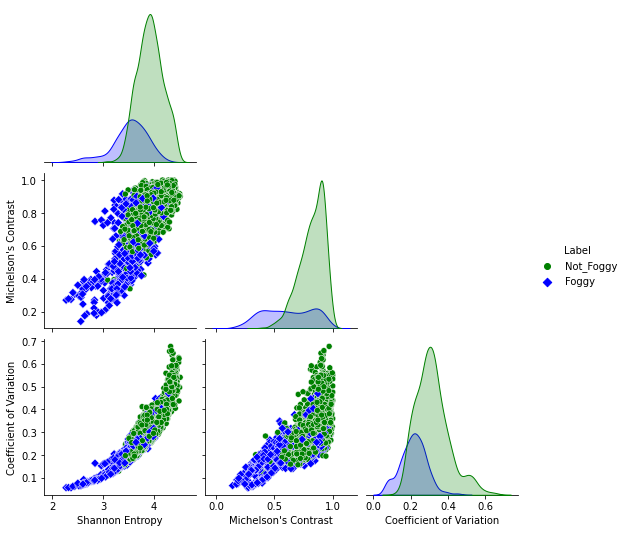

In [15]:
g = sns.pairplot(plot_data, hue = 'Label', palette={'Foggy': 'blue', 'Not_Foggy': 'green'}, markers=["o", "D"], corner=True)
g.axes[2, 0].set_ylabel('Coefficient of Variation')
g.axes[1, 0].set_ylabel('Michelson\'s Contrast')
g.axes[0, 0].set_ylabel('Shannon Entropy')

g.axes[2, 2].set_xlabel('Coefficient of Variation')
g.axes[2, 1].set_xlabel('Michelson\'s Contrast')
g.axes[2, 0].set_xlabel('Shannon Entropy')
# # g.set_axis_labels('Coefficient of Variation', 'Michelson\'s Contrast', 'Shannon Entropy')

/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


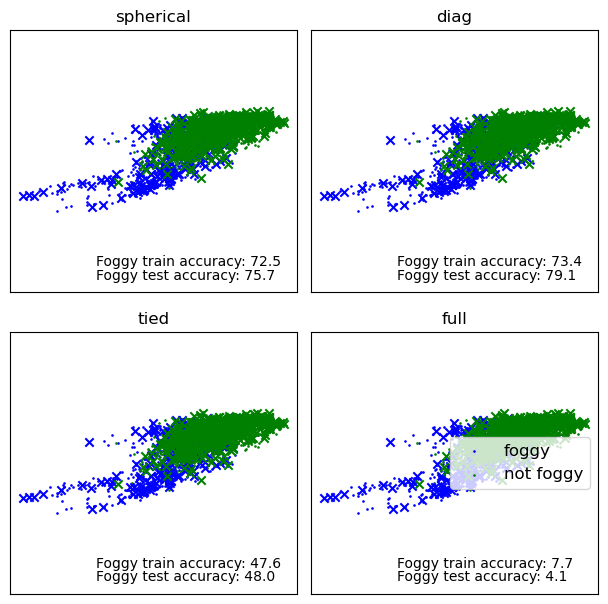

In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["blue", "green"]
names = ["foggy", "not foggy"]

X = np.concatenate((cv.reshape(2259,1), mc.reshape(2259,1), np.array(H).reshape(2259,1)), axis = 1)
y =  np.array([0 if x == "Foggy" else 1 for x in np.array(plot_data.Label)])
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=2)
# next(skf.split(X, y))
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42)

n_classes = len(np.unique(y_train))


# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(X, y)))


X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]


# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = X[y == n]
        plt.scatter(
            data[:, 2], data[:, 1], s=0.8, color=color, label=names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 2], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    # train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    train_accuracy = np.mean(y_train_pred[np.where(y_train==0)] == 0)*100
    plt.text(0.3, 0.1, "Foggy train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    # test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    test_accuracy = np.mean(y_test_pred[np.where(y_test==0)] == 0)*100
    plt.text(0.3, 0.05, "Foggy test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    # plt.xlim(0.6, .7)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)
    # plt.ylim(y_min, y_max)
# plt.xlim(0, .5)

plt.legend(scatterpoints=1, loc="center right", prop=dict(size=12))


plt.show()


In [ ]:
# X = X_transformed_no[:,1]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42)

n_classes = len(np.unique(y_train))


# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(X, y)))


X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]
# X = np.concatenate(
#     (image_sensitive[links_and_labels.loc[links_and_labels['site'] ==site_test].index,:]
#     ,X_transformed_no[:,1].reshape(len(X_transformed_no[:,1]),1))
#     , axis = 1)

estimator = GaussianMixture(
        n_components=2, covariance_type="spherical", max_iter=20, random_state=0
    )
estimator.means_init = np.array(
    [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
)


fitted_model = estimator.fit(X)

pred_values = fitted_model.predict(X)
print(fitted_model.means_)
print(pred_values.reshape(-1,1).shape)
plot_data
plot_data['pred'] = pred_values.reshape(-1,1)
# plot_data
pd.crosstab(plot_data['pred'], plot_data['Label'])

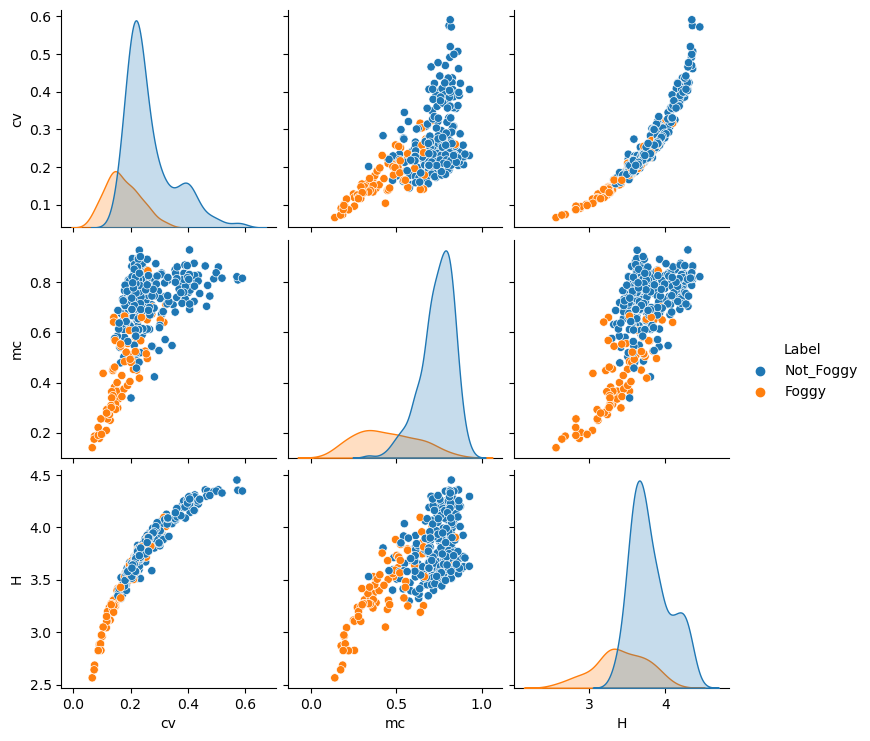

In [ ]:
sns.pairplot(plot_data.loc[plot_data['site']==site_test], hue = 'Label')

In [18]:
####### SPCA
tt = links_and_labels.groupby(['Label', 'site'])['Url'].count().reset_index()
tt['Percentage'] = tt.groupby('site')['Url'].apply(lambda x: x / x.sum() * 100)
tt
# sns.barplot(data=count_data, x='Group', y='Percentage', hue='Category1', ci=None)
# plt.xlabel('Group')
# plt.ylabel('Percentage of Total')
# plt.title('Percentage of Total for Category1 by Group')
# plt.legend(title='Category1')

# # Show the plot
# plt.tight_layout()
# plt.show()

,Label,site,Url,Percentage
0,Foggy,agatebeachor,84,23.140496
1,Foggy,beverlyor,83,22.554348
2,Foggy,cannonbeach,69,21.428571
3,Foggy,lincolncityor,175,42.168675
4,Foggy,otterrockor,92,23.958333
5,Foggy,pacificcityor,88,21.621622
6,Not_Foggy,agatebeachor,279,76.859504
7,Not_Foggy,beverlyor,285,77.445652
8,Not_Foggy,cannonbeach,253,78.571429
9,Not_Foggy,lincolncityor,240,57.831325


(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35'),
  Text(0, 40.0, '40'),
  Text(0, 45.0, '45')])

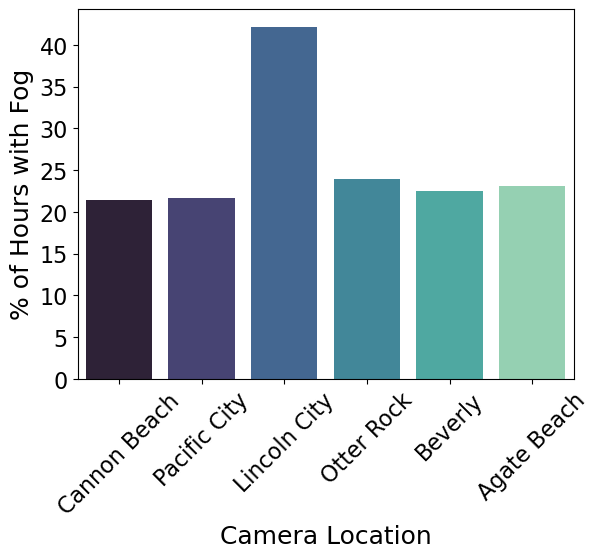

In [19]:
sns.barplot(data=tt.loc[tt['Label']=='Foggy'], x="site", y="Percentage"
            ,palette = 'mako', order = ['cannonbeach', 'pacificcityor','lincolncityor' ,'otterrockor','beverlyor','agatebeachor'])
plt.xticks(rotation=45)
plt.xticks(range(6)
           , ['Cannon Beach', 'Pacific City','Lincoln City' ,'Otter Rock','Beverly','Agate Beach']
           ,rotation=45)  # Set custom tick labels
plt.ylabel('% of Hours with Fog', size = 18)
plt.xlabel('Camera Location', size = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [92]:
site_test = 'otterrockor'

image_data.loc[links_and_labels.loc[links_and_labels['site'] ==site_test].index,:]

,H,mc,cv
5,3.817741,0.995676,0.324745
14,4.196363,0.899884,0.349188
17,4.240886,0.892451,0.406187
20,3.816676,0.899216,0.257300
22,3.784916,0.900621,0.240781
...,...,...,...
2217,3.730484,0.897597,0.250453
2223,3.835994,0.909651,0.268919
2224,3.439992,0.914646,0.197436
2225,3.874962,0.892473,0.274629


In [93]:
X = image_data.loc[links_and_labels.loc[links_and_labels['site'] ==site_test].index,['H', 'mc']]
plot_site =  plot_data.loc[plot_data['site'] ==site_test].copy()

plot_site

,H,mc,cv,Label,site
5,3.817741,0.995676,0.324745,Not_Foggy,otterrockor
14,4.196363,0.899884,0.349188,Not_Foggy,otterrockor
17,4.240886,0.892451,0.406187,Not_Foggy,otterrockor
20,3.816676,0.899216,0.257300,Not_Foggy,otterrockor
22,3.784916,0.900621,0.240781,Not_Foggy,otterrockor
...,...,...,...,...,...
2217,3.730484,0.897597,0.250453,Not_Foggy,otterrockor
2223,3.835994,0.909651,0.268919,Not_Foggy,otterrockor
2224,3.439992,0.914646,0.197436,Not_Foggy,otterrockor
2225,3.874962,0.892473,0.274629,Foggy,otterrockor


In [94]:


# X = np.concatenate(
#     (image_sensitive[links_and_labels.loc[links_and_labels['site'] ==site_test].index,:]
#     ,X_transformed_no[:,1].reshape(len(X_transformed_no[:,1]),1))
#     , axis = 1)

estimator = GaussianMixture(
        n_components=2, covariance_type="diag", max_iter=20, random_state=0
    )
fitted_model = estimator.fit(X)

pred_values = fitted_model.predict(X)
print(fitted_model.means_)

plot_site['Predicted'] = np.where(pred_values.reshape(-1,1), 'Foggy', 'Not Foggy')
# plot_site
pd.crosstab(plot_site['Predicted'], plot_site['Label'])

[[3.60778336 0.86555584]
 [3.99756948 0.92304591]]


/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Label,Foggy,Not_Foggy
Predicted,,
Foggy,65,280
Not Foggy,27,12


<Axes: xlabel='H', ylabel='mc'>

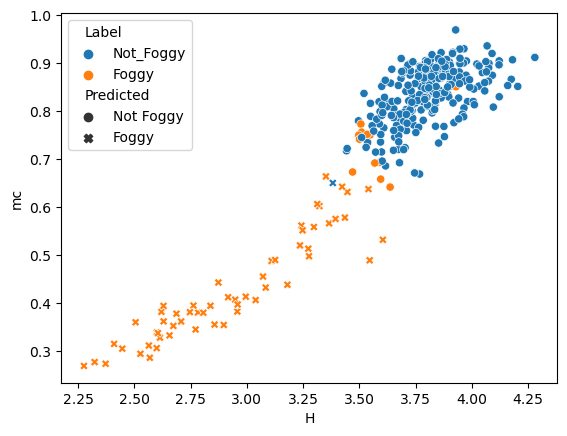

In [65]:
sns.scatterplot(data = plot_site, x = 'H', y = 'mc', hue = 'Label', style = 'Predicted')

In [32]:
Z.shape
XX.shape

(2500, 2)

In [36]:
XX[:,0]

array([2.        , 2.06122449, 2.12244898, ..., 4.87755102, 4.93877551,
       5.        ])

In [73]:
i

1

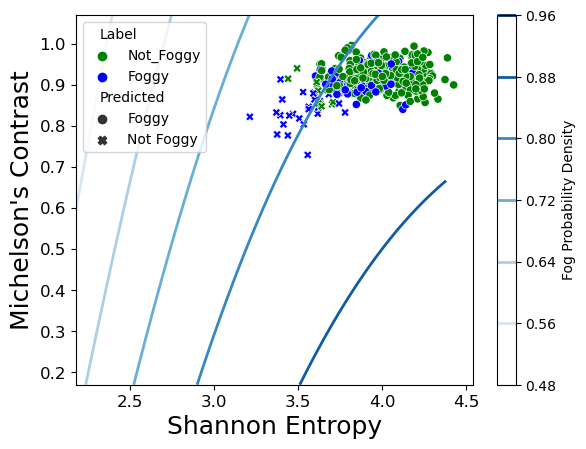

In [95]:
# Generate a range of values for X and Y to create a 2D meshgrid
# x_min, x_max = X['H'].min() - .1, X['H'].max() + .1
# y_min, y_max = X['mc'].min() - .1, X['mc'].max() + .1
# x_range = np.linspace(x_min, x_max, 100)
# y_range = np.linspace(y_min, y_max, 100)
# X_grid, Y_grid = np.meshgrid(x_range, y_range)
# grid_data = np.c_[X_grid.ravel(), Y_grid.ravel()]
# Calculate the probability density for each component on the 2D grid
probs = gmm.predict_proba(grid_data)
# Plot the probability density as contour plots
sns.scatterplot(data = plot_site, x = 'H', y = 'mc', hue = 'Label', style = 'Predicted', palette={'Foggy': 'blue', 'Not_Foggy': 'green'})

# # plt.figure(figsize=(8, 6))
# # for i in range(n_components):
plt.contour(X_grid, Y_grid, probs[:, 0].reshape(100, 100),cmap='Blues' ,levels=6, linewidths=2)
color_bar = plt.colorbar()
color_bar.set_label('Fog Probability Density')
# plt.contour(X_grid, Y_grid, probs[:, 1].reshape(100, 100),cmap='Greens', levels=6, linewidths=2)
# color_bar = plt.colorbar()
# color_bar.set_label('No Fog Probability Density')
# # plt.xlabel('X')
# # plt.ylabel('Y')
# # plt.title('Gaussian Mixture Model Probability Density')
# # plt.show()

# plt.legend(scatterpoints=1, loc="upp right", prop=dict(size=12))
plt.xlabel('Shannon Entropy', fontsize = 18)

plt.ylabel('Michelson\'s Contrast', fontsize = 18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axis("tight")
plt.show()

In [122]:
np.logspace(0, 2,6, 7,8,10)

TypeError: Cannot interpret '10' as a data type

In [ ]:


# start = timeit.default_timer()
# transformer_no = SparsePCA(n_components=2, random_state=0)
# transformer_no.fit(wavelet_site)

# X_transformed_no = transformer_no.transform(wavelet)

# print(X_transformed_no.shape)

# print(np.mean(transformer_no.components_ == 0))

# print('SPCA', np.round((timeit.default_timer() - start)/60, 2), 'minutes')


(2259, 2)
0.87256006006006
SPCA 0.35 minutes


In [ ]:
# links_and_labels.loc[links_and_labels['site'] ==site_test].Label.reset_index().Label

0      Not_Foggy
1      Not_Foggy
2      Not_Foggy
3      Not_Foggy
4      Not_Foggy
         ...    
317    Not_Foggy
318    Not_Foggy
319    Not_Foggy
320    Not_Foggy
321    Not_Foggy
Name: Label, Length: 322, dtype: object

In [58]:
# plot_data = pd.DataFrame(X_transformed_no, columns = ['SPCA1', 'SPCA2'])
# # plot_data = pd.DataFrame(X_transformed_no, columns = ['SPCA1', 'SPCA2', 'SPCA3', 'SPCA4', 'SPCA5'])

# plot_data['labels'] = links_and_labels.loc[links_and_labels['site'] ==site_test].Label.reset_index().Label
# plot_data
# sns.pairplot(plot_data, hue = 'labels')

In [59]:
# len(X_transformed_no[:,1])

In [196]:
plot_data['pred'] = pred_values.reshape(-1,1)
plot_data
pd.crosstab(plot_data['pred'], plot_data['labels'])

labels,Foggy,Not_Foggy
pred,,
0,64,22
1,20,257


In [194]:
# gmm = np.concatenate((X,pred_values.reshape(-1,1)), axis = 1)
# plot_data = pd.DataFrame(gmm, columns = ['SPCA1','SPCA2', 'pred'])

plot_data['pred'] = pred_values.reshape(-1,1)
plot_data
pd.crosstab(plot_data['pred'], plot_data['labels'])

labels,Foggy,Not_Foggy
pred,,
0,70,38
1,14,241


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0.0, -0.7], [3.5, 0.7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20.0, 30.0)
y = np.linspace(-20.0, 40.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(X_train[:, 0], X_train[:, 1], 0.8)

plt.title("Negative log-likelihood predicted by a GMM")
plt.axis("tight")
plt.show()